<a href="https://colab.research.google.com/github/riyabharath24/Handball-Action-Recognition/blob/main/Handball_Action_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### ACTION RECOGNITION ON THE HANDBALL DATASET

1. IMPORTING THE REQUIRED LIBRARIES

In [1]:
%%capture

!pip install pafy youtube-dl moviepy
!pip install git+https://github.com/ytdl-org/youtube-dl.git@master#egg=youtube_dl

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Import the required libraries
import os
import cv2
import pafy
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

#from moviepy.editor import *
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [4]:
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [5]:
#discard the output of the cell.
%%capture

#Extract the Dataset
!unzip '/content/drive/MyDrive/uniri-hbd.zip'

2. VISUALIZING THE DATASET

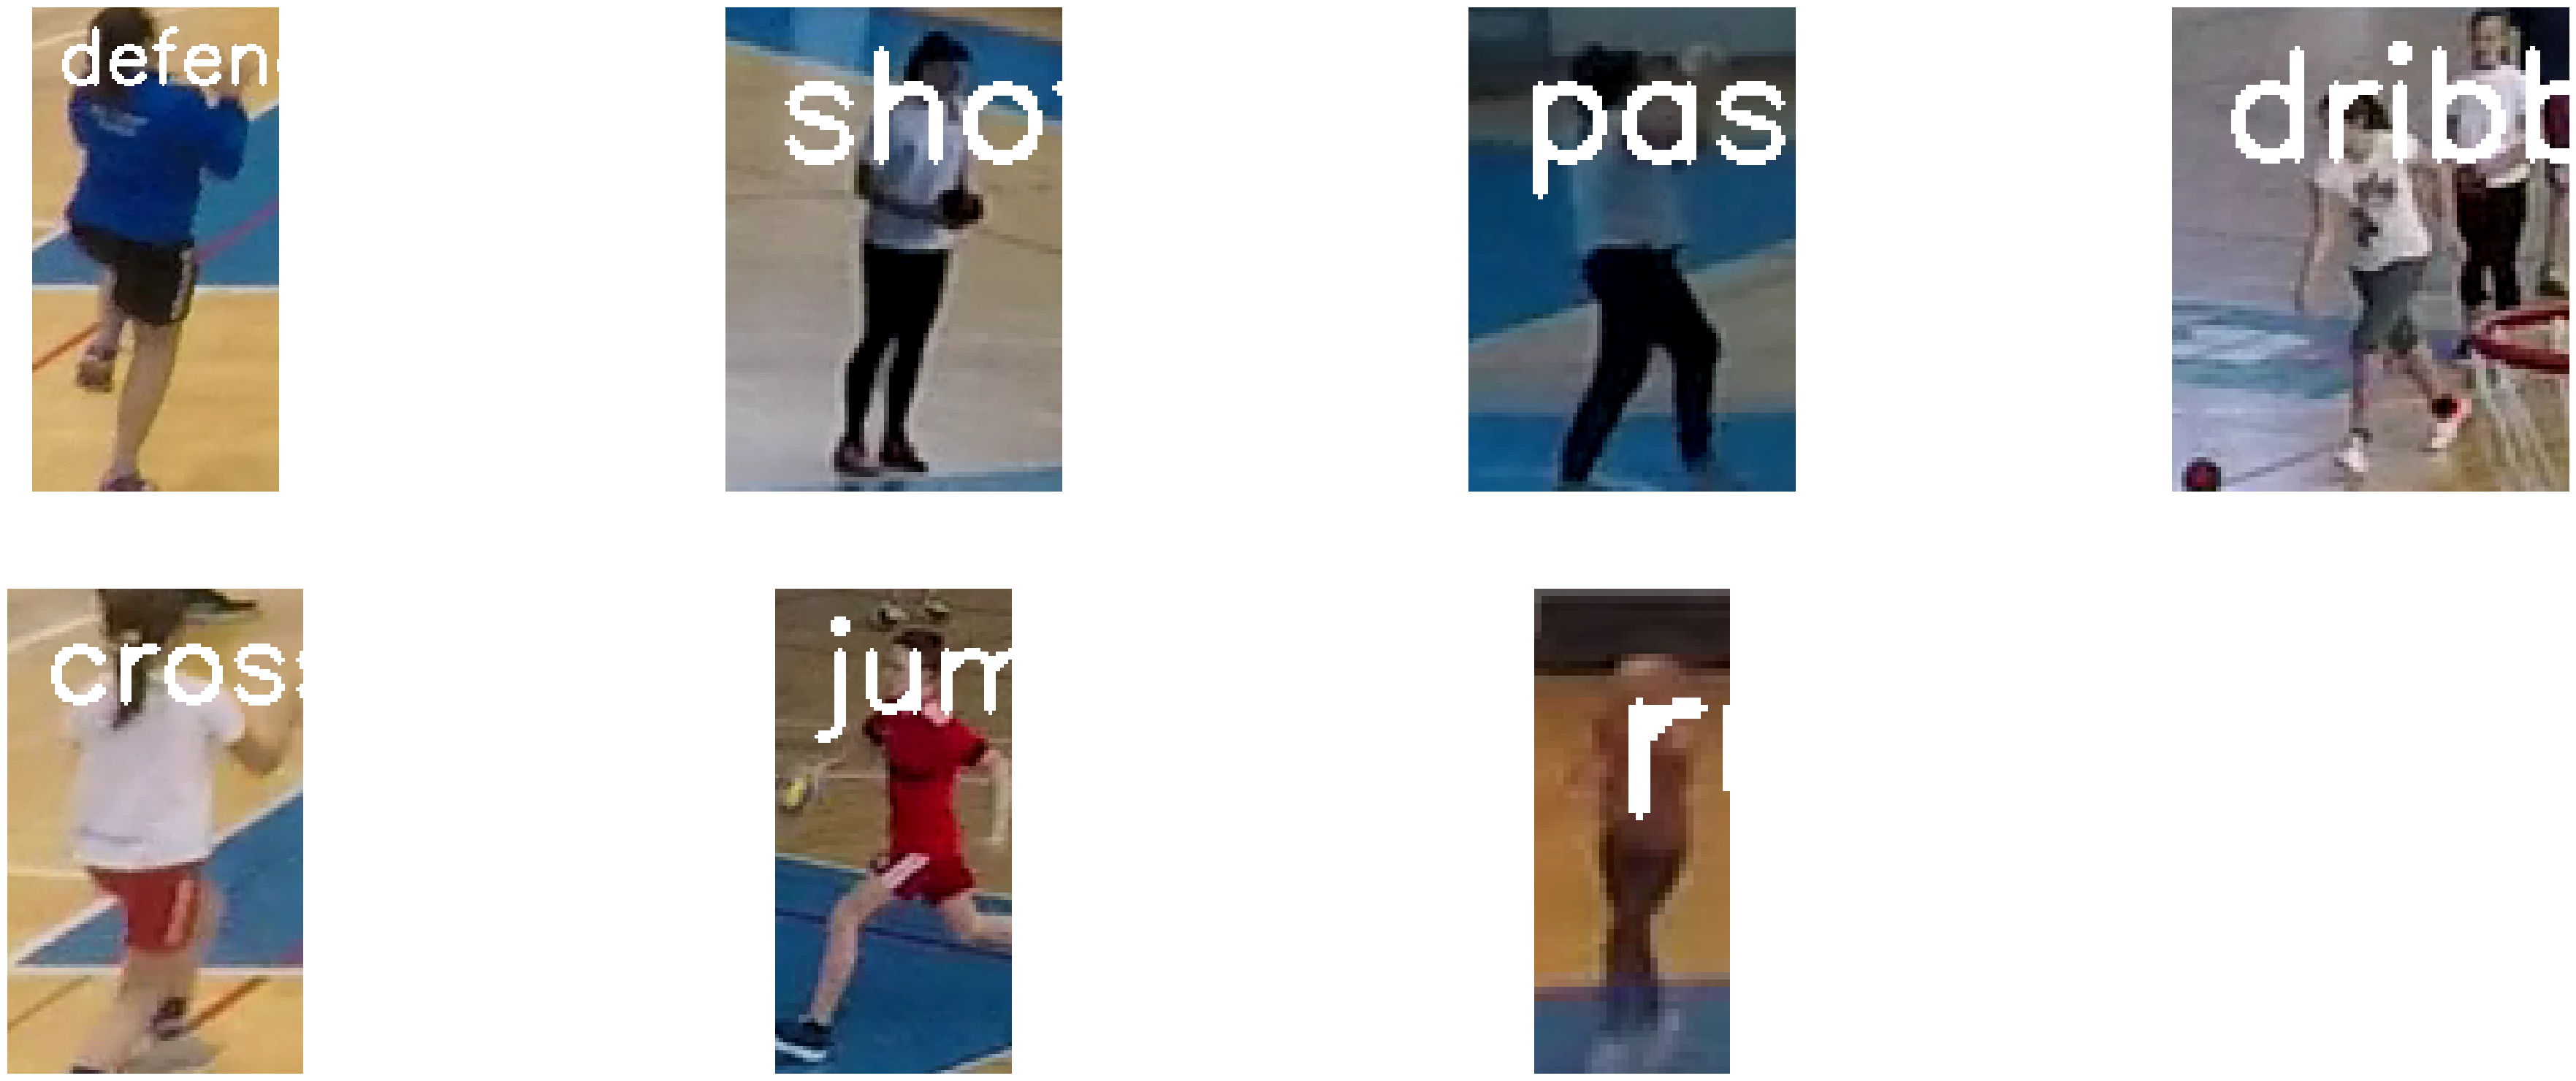

In [7]:
plt.figure(figsize = (50,50))

all_classes_names = os.listdir('/content/uniri-hbd - Copy/handball_s/actions')

random_range = random.sample(range(len(all_classes_names)), 7)


for counter, random_index in enumerate(random_range, 1):

  selected_class_name = all_classes_names[random_index]

  video_files_names_list = os.listdir(f'/content/uniri-hbd - Copy/handball_s/actions/{selected_class_name}')

  selected_video_file_name = random.choice(video_files_names_list)

  video_reader = cv2.VideoCapture(f'/content/uniri-hbd - Copy/handball_s/actions/{selected_class_name}/{selected_video_file_name}')

  #read the first frame of the video file
  _, bgr_frame = video_reader.read()

  #Release the VideoCapture object.
  video_reader.release()

  #Convert the frame from BGR into RGB format
  rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

  # Write the class name on the video frame
  cv2.putText(rgb_frame, selected_class_name, (10,30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

  # Display the frame
  plt.subplot(5, 4, counter);plt.imshow(rgb_frame);plt.axis('off')




### Preprocessing

In [8]:
IMAGE_HEIGHT, IMAGE_WIDTH = 64, 64

SEQUENCE_LENGTH = 20

DATASET_DIR = '/content/uniri-hbd - Copy/handball_s/actions'

CLASSES_LIST = ["jump-shot", "dribbling", "crossing", "defence",]

In [9]:
def frames_extraction(video_path):

  # Declare a list to store video frames.
  frames_list = []

  video_reader = cv2.VideoCapture(video_path)

  #Get the total number of frames in the video
  video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

  skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

  # Iterate through the video frames
  for frame_counter in range(SEQUENCE_LENGTH):

    video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

    success, frame = video_reader.read()

    # Check if Video frame is not successfully read then break the loop
    if not success:
      break

    # Resize the Frame to fixed height and width
    resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

    # Normalize the resized frame by dividing it with 255 
    normalized_frame = resized_frame / 255

    #Append the normalized frame into the frames list
    frames_list.append(normalized_frame)

  # Release the VideoCapture object
  video_reader.release()

  # Return the frames list
  return frames_list

In [10]:
def dataset_create():

    #Declare Empty Lists to store the features, labels and video file paths
    features = []
    labels = []
    video_files_paths = []

    for class_index, class_name in enumerate(CLASSES_LIST):
      print(f'Extracting Data of Class: {class_name}')
      files_list = os.listdir(os.path.join(DATASET_DIR, class_name))

      for file_name in files_list:
        video_file_path = os.path.join(DATASET_DIR, class_name, file_name)
        frames = frames_extraction(video_file_path)

        if len(frames) == SEQUENCE_LENGTH:
          features.append(frames)
          labels.append(class_index)
          video_files_paths.append(video_file_path)

    features = np.asarray(features)
    labels = np.array(labels)

    return features, labels, video_files_paths


In [11]:
# Creating the dataset
features, labels, video_files_paths = dataset_create()

Extracting Data of Class: jump-shot
Extracting Data of Class: dribbling
Extracting Data of Class: crossing
Extracting Data of Class: defence


In [12]:
#Using Keras to convert labels into one-hot-encoded vectors
one_hot_encoded_labels = to_categorical(labels)

In [13]:
# Splitting the Data into Train and Test sets
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels,
                                                                            test_size = 0.25, shuffle = True,
                                                                            random_state = seed_constant)

In [14]:
def create_LRCN_model():
    '''
    This function will construct the required LRCN model.
    Returns:
        model: It is the required constructed LRCN model.
    '''

    # We will use a Sequential model for model construction.
    model = Sequential()
    
    # Define the Model Architecture.
    ########################################################################################################################
    
    model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same',activation = 'relu'),
                              input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    
    model.add(TimeDistributed(MaxPooling2D((4, 4)))) 
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    #model.add(TimeDistributed(Dropout(0.25)))
                                      
    model.add(TimeDistributed(Flatten()))
                                      
    model.add(LSTM(32))
                                      
    model.add(Dense(len(CLASSES_LIST), activation = 'softmax'))

    ########################################################################################################################

    # Display the models summary.
    model.summary()
    
    # Return the constructed LRCN model.
    return model

In [15]:
# Construct the required LRCN model
LRCN_model = create_LRCN_model()

# Display the success message
print("Model Created Successfully!")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 20, 64, 64, 16)   448       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 20, 16, 16, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 20, 16, 16, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 20, 16, 16, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 20, 4, 4, 32)     0

In [16]:
# Create an Instance of Early Stopping Callback
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience=15, mode = 'min', restore_best_weights=True)

# Compile the model and specify loss function, optimizer and metrics to the model
LRCN_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics=['accuracy'])

# Start training the model
LRCN_model_training_history = LRCN_model.fit(x = features_train, y = labels_train, epochs = 70, batch_size=4,
                                             shuffle=True, validation_split=0.2, callbacks = [early_stopping_callback])

Epoch 1/70
84/84 [==============================] - 27s 266ms/step - loss: 1.0864 - accuracy: 0.4760 - val_loss: 1.0467 - val_accuracy: 0.4643
Epoch 2/70
84/84 [==============================] - 23s 278ms/step - loss: 1.0030 - accuracy: 0.5958 - val_loss: 0.9730 - val_accuracy: 0.5833
Epoch 3/70
84/84 [==============================] - 20s 239ms/step - loss: 0.8916 - accuracy: 0.6377 - val_loss: 0.8482 - val_accuracy: 0.6905
Epoch 4/70
84/84 [==============================] - 23s 279ms/step - loss: 0.8230 - accuracy: 0.6976 - val_loss: 0.7845 - val_accuracy: 0.7262
Epoch 5/70
84/84 [==============================] - 22s 266ms/step - loss: 0.7534 - accuracy: 0.7246 - val_loss: 0.7060 - val_accuracy: 0.7143
Epoch 6/70
84/84 [==============================] - 21s 248ms/step - loss: 0.6973 - accuracy: 0.7365 - val_loss: 0.7889 - val_accuracy: 0.7143
Epoch 7/70
84/84 [==============================] - 21s 253ms/step - loss: 0.6927 - accuracy: 0.7335 - val_loss: 0.5859 - val_accuracy: 0.7619

In [17]:
model_evaluation_history = LRCN_model.evaluate(features_test, labels_test)

5/5 [==============================] - 4s 784ms/step - loss: 0.1610 - accuracy: 0.9357


In [18]:
# Saving the model
# Get the loss and accuracy from model_evaluation_history
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

# Date and Time in a DateTime Object
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

# Defining a useful name for our model to make it easy for us while navigating
model_file_name = f'LRCN_model__Date_Time_{current_date_time_string}__Loss_{model_evaluation_loss}__Accuracy_{model_evaluation_accuracy}.h5'

# Save the Model
LRCN_model.save(model_file_name)

In [19]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):

  # Getting metric values
  metric_value_1 = model_training_history.history[metric_name_1]
  metric_value_2 = model_training_history.history[metric_name_2]

  # Construct a range object which will be used as x-axis
  epochs = range(len(metric_value_1))

  # Plot the Graph
  plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
  plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

  # Add title to the plot
  plt.title(str(plot_name))

  # Add legend to the plot
  plt.legend()

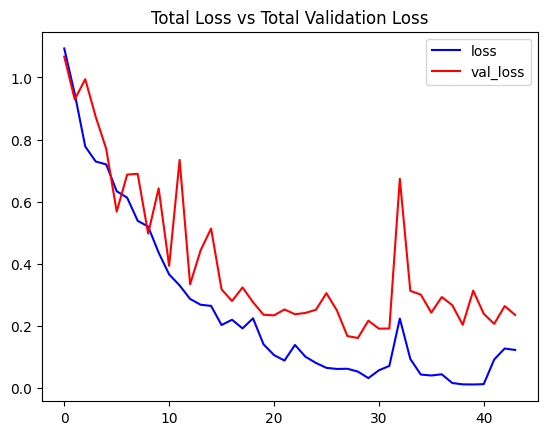

In [ ]:
# Visualize the training and validation loss metrices
plot_metric(LRCN_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

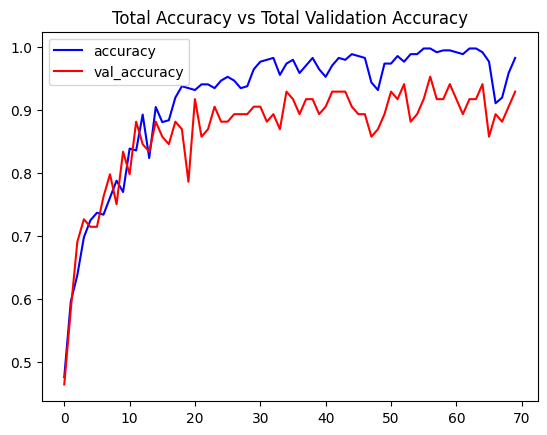

In [20]:
# Visualize the training and validation accuracy metrices.
plot_metric(LRCN_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy') 

In [37]:
# Make the Output directory if it does not exist
test_videos_directory = 'test_videos'
os.makedirs(test_videos_directory, exist_ok = True)

# Get the Video's path we just downloaded.
input_video_file_path = f'/content/uniri-hbd - Copy/handball_s/actions/jump-shot/jump-shot_KS_129_act1.avi'


### Action Recognition on Videos

In [38]:
def predict_on_video(video_file_path, output_file_path, SEQUENCE_LENGTH):

  video_reader = cv2.VideoCapture(video_file_path)

  original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
  original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

  video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc('M', 'P', '4', 'V'),
                                 video_reader.get(cv2.CAP_PROP_FPS), (original_video_width, original_video_height))
  
  # Declare a queue to store video frames
  frames_queue = deque(maxlen = SEQUENCE_LENGTH)

  # Initialize a variable to store predicted action
  predicted_class_name = ''

  # Iterate until video is accessed successfully
  while video_reader.isOpened():

    ok, frame = video_reader.read()

    # Check if frame is not read properly then break loop
    if not ok:
      break

    resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

    # Normalize the resized frame by dividing it with 255
    normalized_frame = resized_frame / 255

    # Appending the pre-processed frame into the frames list
    frames_queue.append(normalized_frame)

    if len(frames_queue) == SEQUENCE_LENGTH:

      # Pass the normalized frames into model to get predicted probabilities
      predicted_labels_probabilities = LRCN_model.predict(np.expand_dims(frames_queue, axis = 0))

      predicted_label = np.argmax(predicted_labels_probabilities)

      predicted_class_name = CLASSES_LIST[predicted_label]

    cv2.putText(frame, predicted_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    # Write the frame into the disk
    video_writer.write(frame)

  video_reader.release()
  video_writer.release()

  print(f'Predicted Action : {predicted_class_name}')

In [39]:
from moviepy.editor import *

# Construct the output video path
output_video_file_path = f'{input_video_file_path}-Output-SeqLen{SEQUENCE_LENGTH}.mp4'

# Perform Action Recognition on the Test Video
predict_on_video(input_video_file_path, output_video_file_path, SEQUENCE_LENGTH)

# Display the output video
VideoFileClip(output_video_file_path, audio=False, target_resolution=(300,None)).ipython_display()

1/1 [==============================] - 0s 45ms/step
Predicted Action : jump-shot
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4
